In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yiweilu2033/well-documented-alzheimers-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/well-documented-alzheimers-dataset


In [2]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        # Omitir la carpeta "ModerateDemented"
        if folder == "ModerateDemented":
            continue

        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
                print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


NonDemented (2): 63560 imágenes
VeryMildDemented: 13796 imágenes
MildDemented: 5184 imágenes


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Directorio base donde están las imágenes
base_dir = path  # ← asegúrate de tener esta variable definida

# Diccionario con las carpetas relevantes
category_subfolders = {
    "MildDemented": "MildDemented",
    "VeryMildDemented": "VeryMildDemented",
    "NonDemented (2)": "NonDemented"
}

# Inicializamos listas
image_paths = []
patient_ids = []
labels = []

# Recorrer el dataset e indexar imágenes
for category, subfolder in category_subfolders.items():
    category_path = os.path.join(base_dir, category, subfolder)

    if not os.path.exists(category_path):
        print(f"Advertencia: No se encontró la carpeta {category_path}, se omitirá.")
        continue

    for img_name in os.listdir(category_path):
        if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            patient_id = "_".join(img_name.split("_")[:3])
            image_paths.append(os.path.join(category_path, img_name))
            patient_ids.append(patient_id)
            labels.append(category)

# Crear DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": labels
})

# Limitar a 1000 imágenes por clase (por paciente, sin cortar pacientes)
limited_df_parts = []

for label in df['label'].unique():
    subset = df[df['label'] == label].copy()
    patients = subset.groupby('patient_id')

    total_images = 0
    selected_patient_ids = []

    for pid, group in patients:
        if total_images + len(group) > 5000:
            continue  # No añadimos si pasamos de 1000
        selected_patient_ids.append(pid)
        total_images += len(group)

        if total_images >= 15000:
            break

    limited_df_parts.append(subset[subset['patient_id'].isin(selected_patient_ids)])

# Unir los subconjuntos limitados
limited_df = pd.concat(limited_df_parts).reset_index(drop=True)

# Actualizar etiquetas únicas
patient_labels = limited_df.groupby('patient_id')['label'].first()

# Dividir pacientes
unique_patient_ids = limited_df["patient_id"].unique()

train_ids, test_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42, stratify=patient_labels.loc[unique_patient_ids]
)

train_ids, val_ids = train_test_split(
    train_ids, test_size=0.2, random_state=42, stratify=patient_labels.loc[train_ids]
)

# Crear splits finales
train_data = limited_df[limited_df["patient_id"].isin(train_ids)]
val_data = limited_df[limited_df["patient_id"].isin(val_ids)]
test_data = limited_df[limited_df["patient_id"].isin(test_ids)]

# Crear DataFrame final con etiqueta de conjunto
final_df = limited_df.copy()
final_df["set"] = final_df["patient_id"].apply(
    lambda pid: 'train' if pid in train_ids else ('val' if pid in val_ids else 'test')
)

# Imprimir verificación
print(f"Tamaño de entrenamiento: {len(train_data)}")
print(f"Tamaño de validación: {len(val_data)}")
print(f"Tamaño de prueba: {len(test_data)}")
print(final_df['label'].value_counts())
print(final_df['set'].value_counts())
print(final_df.head())


Tamaño de entrenamiento: 9524
Tamaño de validación: 2375
Tamaño de prueba: 3069
label
MildDemented        5000
NonDemented (2)     5000
VeryMildDemented    4968
Name: count, dtype: int64
set
train    9524
test     3069
val      2375
Name: count, dtype: int64
                                          image_path     patient_id  \
0  /kaggle/input/well-documented-alzheimers-datas...  OAS1_0073_MR1   
1  /kaggle/input/well-documented-alzheimers-datas...  OAS1_0316_MR1   
2  /kaggle/input/well-documented-alzheimers-datas...  OAS1_0184_MR1   
3  /kaggle/input/well-documented-alzheimers-datas...  OAS1_0269_MR1   
4  /kaggle/input/well-documented-alzheimers-datas...  OAS1_0316_MR1   

          label    set  
0  MildDemented  train  
1  MildDemented  train  
2  MildDemented  train  
3  MildDemented    val  
4  MildDemented  train  


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Transformaciones (iguales para todos)
transform = transforms.Compose([
    transforms.Resize((64, 64)),                 # Redimensionar la imagen
    transforms.RandomHorizontalFlip(p=0.5),        # Volteo aleatorio horizontal
    transforms.RandomRotation(degrees=15),         # Rotación aleatoria
    transforms.ToTensor(),                         # Convertir la imagen a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
])

# Mapeo de etiquetas a números (sin "ModerateDemented")
label_map = {"MildDemented": 0, "VeryMildDemented": 1, "NonDemented (2)": 2}

class AlzheimerDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset de Alzheimer.

        Args:
        df (pd.DataFrame): DataFrame con las rutas de imágenes y las etiquetas.
        transform (callable, optional): Transformaciones a aplicar a cada imagen.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """Devuelve el número total de muestras (imágenes) en el dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Obtiene una imagen y su etiqueta correspondiente del DataFrame.

        Args:
        idx (int): Índice de la muestra.

        Returns:
        image (Tensor): Imagen transformada.
        label (int): Etiqueta correspondiente a la imagen.
        """
        img_path = self.df.iloc[idx]["image_path"]
        label = label_map[self.df.iloc[idx]["label"]]

        # Cargar la imagen
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones (si las hay)
        if self.transform:
            image = self.transform(image)

        return image, label

# Filtrar el DataFrame para excluir "ModerateDemented"
filtered_df = final_df[final_df["label"] != "ModerateDemented"]

# Filtramos los DataFrames para los conjuntos de entrenamiento, validación y prueba
train_df = filtered_df[filtered_df["set"] == "train"]
val_df = filtered_df[filtered_df["set"] == "val"]
test_df = filtered_df[filtered_df["set"] == "test"]

# Crear los datasets de PyTorch
train_dataset = AlzheimerDataset(train_df, transform=transform)
val_dataset = AlzheimerDataset(val_df, transform=transform)
test_dataset = AlzheimerDataset(test_df, transform=transform)

# Verificar el tamaño de cada dataset
print(f"Tamaño del dataset -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Crear los DataLoaders para cargar los datos por lotes
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders creados con batch_size={batch_size}")


Tamaño del dataset -> Train: 9524, Val: 2375, Test: 3069
DataLoaders creados con batch_size=128


In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Cargar modelo MobileNetV2 preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa para clasificación en 3 clases
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

# Enviar al dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Ver estructura del modelo
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 83.5MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

# 1. Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Función para entrenar usando F1-score como criterio
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_f1_scores = []
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_preds

        # VALIDACIÓN
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average='macro')  # o 'weighted'
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1_scores.append(val_f1)

        # Guardar el mejor modelo si el F1 es mayor
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Mejor modelo guardado en la época {epoch+1} con F1: {val_f1:.4f}")

        # Imprimir métricas
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f} - "
              f"Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

    return train_losses, val_f1_scores

# 3. Evaluar usando F1-score
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # o 'weighted'

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return acc, f1

# 4. Entrenamiento
num_epochs = 25
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# 5. Evaluación
test_accuracy, test_f1 = evaluate_model(model, test_loader)




Mejor modelo guardado en la época 1 con F1: 0.4501
Epoch 1/25 - Train Loss: 0.6044, Train Accuracy: 0.7428 - Validation Accuracy: 0.4312, F1 Score: 0.4501
Mejor modelo guardado en la época 2 con F1: 0.4925
Epoch 2/25 - Train Loss: 0.2551, Train Accuracy: 0.9003 - Validation Accuracy: 0.5053, F1 Score: 0.4925
Epoch 3/25 - Train Loss: 0.1669, Train Accuracy: 0.9403 - Validation Accuracy: 0.3747, F1 Score: 0.3812
Epoch 4/25 - Train Loss: 0.1329, Train Accuracy: 0.9552 - Validation Accuracy: 0.4253, F1 Score: 0.4288
Epoch 5/25 - Train Loss: 0.0844, Train Accuracy: 0.9682 - Validation Accuracy: 0.4484, F1 Score: 0.4506
Epoch 6/25 - Train Loss: 0.0684, Train Accuracy: 0.9760 - Validation Accuracy: 0.4657, F1 Score: 0.4638
Epoch 7/25 - Train Loss: 0.0567, Train Accuracy: 0.9816 - Validation Accuracy: 0.4354, F1 Score: 0.4241
Epoch 8/25 - Train Loss: 0.0619, Train Accuracy: 0.9777 - Validation Accuracy: 0.3916, F1 Score: 0.4121
Epoch 9/25 - Train Loss: 0.0587, Train Accuracy: 0.9805 - Validati

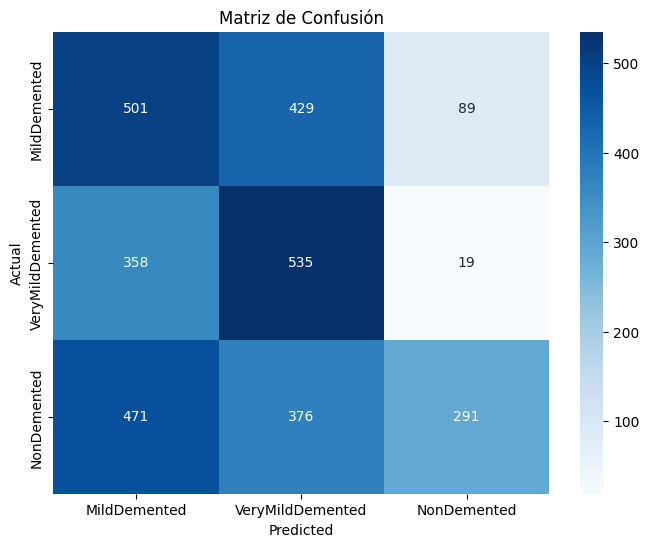

In [7]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluar el modelo en el conjunto de prueba
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Crear la matriz de confusión
labels_classes = ["MildDemented", "VeryMildDemented", "NonDemented"]  # Eliminado "ModerateDemented"
cm = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_classes, yticklabels=labels_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()


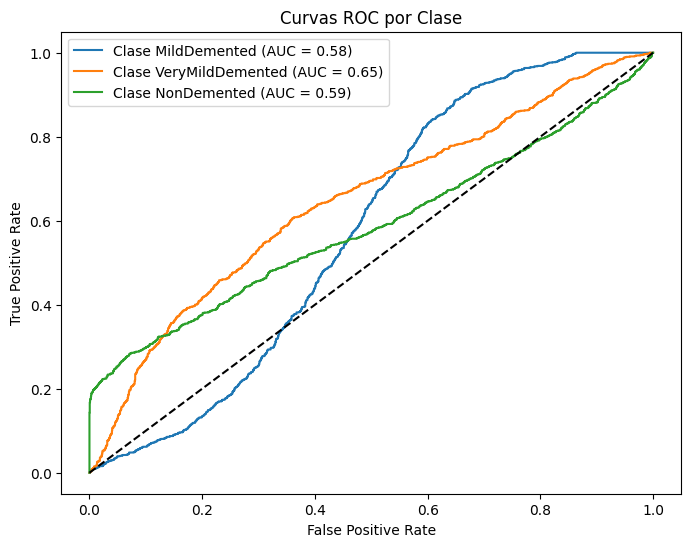

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Convertir las etiquetas en formato binario (one-vs-all) para 3 clases
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Solo 3 clases ahora
y_scores = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)  # Obtiene los logits (valores antes de softmax)
        y_scores.extend(outputs.cpu().numpy())

y_scores = np.array(y_scores)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8,6))
labels_classes = ["MildDemented", "VeryMildDemented", "NonDemented"]  # Sin "ModerateDemented"

for i in range(3):  # Ahora solo 3 clases
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {labels_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC por Clase")
plt.legend()
plt.show()
